# 言語モデル
言語モデルは、単語の並びに対してその文がどれほど自然かという評価を確率で与える。これは、確率分布に則した文章生成にも応用される。$w_1 \cdots w_m$の$m$個の単語からなる文章における場合を数式を用いて表すと、
<br>
$\displaystyle{
P(w_1,\cdots,w_m)=\prod_{t=1}^{m}P(w_t|w_1,\cdots,w_{t-1})
}$
<br>
これは、確率の乗法定理によるものである。これによって、$m$個の単語の同時確率は、事後確率の総乗の形に表すことができる。ここでは、この事後確率は$t$番目の単語より前の全ての単語をコンテキストとすることがわかる。このモデルは、条件付き言語モデルと呼ばれる。

# CBOWモデルと言語モデル
コンテクストのサイズをある値に限定することで、word2vecのCBOWモデルを言語モデルで近似することができる。
<br>
$\displaystyle{
P(w_1,\cdots,w_m)=\prod_{t=1}^{m}P(w_t|w_1,\cdots,w_{t-1}) \approx \prod_{t=1}^{m}P(w_t|w_{t-2},w_{t-1})
}$
<br>

これは、コンテキストを前の2つの単語に限定した場合である。（2階マルコフ連鎖）
<br>
このコンテキストの数は、任意の数に変更できる。しかし、CBOWモデルには、コンテキストにおける単語の並びが無視されるという問題がある。この問題を解決するために、長い時系列データを扱えるRNNという手法を用いる。

# RNN
RNN(Recurrent Neural Network)は、ループする経路を持つ。RNNで用いられるレイヤ（ここではRNNレイヤと呼ぶ）は、以下のような図で表される。
<img src='https://cdn-ak.f.st-hatena.com/images/fotolife/t/taxa_program/20181225/20181225003431.png'>
この図から分かる通り、RNNではデータがレイヤ内を循環できる。ここでは、時系列データとして$(x_0,x_1,\cdots,x_t,\cdots)$が入力され、それに対応した出力として$(h_0,h_1,\cdots,h_t,\cdots)$を出力する。

# RNNのループの展開
RNNレイヤのループを展開すると、ニューラルネットワークのようになることが図から分かる。
<img src='https://cdn-ak.f.st-hatena.com/images/fotolife/t/taxa_program/20181225/20181225005739.png'>
このとき、各時刻のRNNレイヤは1つ前のRNNレイヤの出力を入力として受け取る。そして、各時刻の入力と合わせてまた結果を出力する。このとき行う計算は次のようになっている。
<br>
$\displaystyle{
h_t = \tanh(h_{t-1}W_h+x_tW_x+b)
}$
<br>
$W_x$は入力$x$を出力$h$に変換する重み、$W_h$は1つ前の出力を次の出力に変換する重みである。なお、ここでは$h_{t-1}$と$x_t$は行ベクトルとする。これは、RNNは$h$の値を保持しており、それを更新し続ける形をとるとも言える。

# BPTT
RNNの学習も、今まで同様に逆誤差伝播法によって行うことができる。ここでの誤差逆伝播法は、Backpropagation Through Time(BPTT)と呼ばれる。しかしこの手法では、時系列データの長さに比例して演算量が増えてしまう。また、長くなるほど逆伝播時の勾配が不安定になるという問題もある。

# Truncated BPTT
その問題を解決するためによくい用いられる手法として、ネットワークのつながりを適当な長さで断ち切るというものがある。その小さく分けられたネットワークに対して誤差逆伝播法を用いるのがTruncated BPTTである。この手法では、順伝播のつながりは断ち切らず、逆伝播のつながりだけを断ち切る。これは、学習においてデータをシーケンシャルに（順番に）与える必要があると言うことである。また、バッチ処理を行う場合には各バッチで与えるデータの開始位置をずらす必要がある。

# RNNの実装
ここでは、RNNレイヤを展開した状態の1ステップ分の処理を行うレイヤをRNNレイヤ、先ほどで言うRNNレイヤをTimeRNNレイヤという名前でそれぞれ実装していく。

In [6]:
from common.np import *
from common.layers import *
from common.functions import softmax, sigmoid

class RNN: #RNNレイヤの実装
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev
    
class TimeRNN: #TimeRNNの実装
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# 時系列データを扱うレイヤの実装
ここではRNNによる言語モデルを、RNNLM(RNN Language Model)と呼び、その実装を行う。実装するネットワークは以下の図のようなもの。
<img src='https://cdn-ak.f.st-hatena.com/images/fotolife/t/taxa_program/20181225/20181225010306.png'>
<br>
このネットワークに、実際にコーパスを流してみると以下のようになる。(ただし、ネットワークは正しく重みが学習できている前提)
<br>
<img src='https://cdn-ak.f.st-hatena.com/images/fotolife/t/taxa_program/20190108/20190108000309.png'>

# 各Timeレイヤの実装
今まで使用してきたレイヤを、時系列データを扱えるように実装し直してまとめることで、前述のネットワークをより簡潔に実装できる。

In [7]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [8]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [9]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

これらを実際に組み合わせてRNNLMを実装する。

In [10]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

言語モデルの評価では、パープレキシティが評価の指数として用いられる。これは、正解の確率の逆数であり、小さいほど精度が高いとされる。これは、入力データが一つの時の場合で、複数の場合には、以下の式に従って計算される。<br>
$\displaystyle{
L = -\frac{1}{N}\sum_n\sum_kt_{nk}\log y_{nk} \\
\text{perplexity} = e^L
}$
<br>
$N$はデータの個数、$t_n$はone-hotベクトルの正解ラベル、$t_{nk}$は$n$個目のデータの$k$番目の値を意味する。小さいほど精度が高いとされるのは変わらない。この指標をもとにRNNLMの学習を行う実装を行うと、次のようになる。

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 378.27
| epoch 2 | perplexity 257.19
| epoch 3 | perplexity 225.02
| epoch 4 | perplexity 217.40
| epoch 5 | perplexity 207.12
| epoch 6 | perplexity 202.66
| epoch 7 | perplexity 199.05
| epoch 8 | perplexity 196.91
| epoch 9 | perplexity 191.78
| epoch 10 | perplexity 193.00
| epoch 11 | perplexity 189.74
| epoch 12 | perplexity 192.63
| epoch 13 | perplexity 190.57
| epoch 14 | perplexity 191.46
| epoch 15 | perplexity 190.19
| epoch 16 | perplexity 187.10
| epoch 17 | perplexity 184.47
| epoch 18 | perplexity 181.57
| epoch 19 | perplexity 182.74
| epoch 20 | perplexity 183.73
| epoch 21 | perplexity 182.38
| epoch 22 | perplexity 178.34
| epoch 23 | perplexity 174.97
| epoch 24 | perplexity 176.46
| epoch 25 | perplexity 174.77
| epoch 26 | perplexity 174.46
| epoch 27 | perplexity 168.35
| epoch 28 | perplexity 167.01
| epoch 29 | perplexity 164.28
| epoch 30 | perplexity 157.94
| epoch 31 | perplexity 160.01
| e

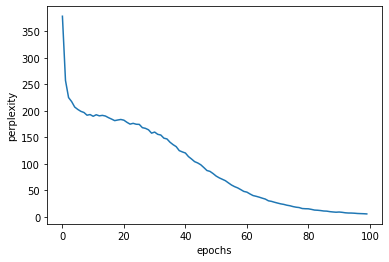

In [14]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

順調にperplexityが減少していることがわかる。しかし、これは小さなコーパスサイズのデータを扱ったものであり、大きくなると現状のモデルでは問題がある。

# RNNLMのTrainerクラス
RNNLMの学習を行う、RnnlmTrainerクラスを実装する。この内部では、以下のような作業が行われる。
1. ミニバッチをシーケンシャルに作成
1. モデルの順伝播と逆伝播を実行
1. optimizerで重みを更新
1. perplexityを評価

In [22]:
import time
import numpy

class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()
        
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.02
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 371.96
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 256.57
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 221.47
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 208.72
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 207.40
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 199.96
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.01
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 193.93
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.23
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 190.70
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 187.95
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.05
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 185.88
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 184.98
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 188.21
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 186.49
| epoch 18 |  iter 1 / 

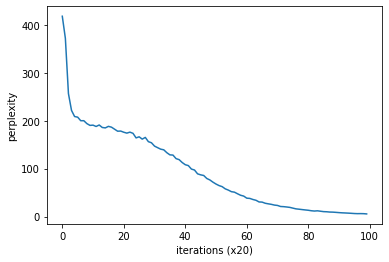

In [23]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

# RNNの問題点
今実装したRNNでは、長期にわたる時系列データの依存関係を学習することが苦手である。これは、BPTTのにおける勾配消失や勾配爆発によるものである。

# 勾配消失と勾配爆発
例として、以下の文章の空欄を予測する問題を考える。
> Tom was watching TV in his room. Mary came into the room. Mary said hi to （　　　　）.

この場合、答えはTomになる。これを正しく予測するためには、Tomが部屋にいるということと、その部屋にMaryが入ったということをRNNLMが記憶しておく必要がある。しかし、前述のRNNネットワークでは、多くの場合逆伝播時に伝播される勾配が消失、または爆発してしまう。

# 勾配消失と勾配爆発の原因
RNNレイヤの内部においては、図のような構造になっており、逆伝播を行っている。
<img src='https://yaserarenai.com/post/20211030/graph1.webp'>
この図を見ると、逆伝播時には勾配が「tanh」「+」「MatMul」を通過することが分かる。「+」に関しては、勾配をそのまま伝播するだけであるため、勾配に変化はない。「tanh」においては、勾配は微分される。tanh関数における微分は、グラフにおいて以下のように表される。

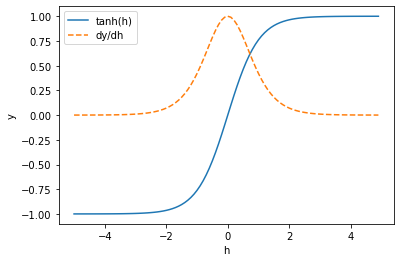

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 入力データの範囲(x軸の描画範囲)を指定
h = np.arange(-5.0, 5.0, 0.1)

# tanh関数を計算
y = np.tanh(h)

# tanh関数の微分を計算
dy = 1 - y**2

#グラフの描画
plt.plot(h, y, label='tanh(h)')
plt.plot(h, dy, linestyle='--', label='dy/dh')
plt.xlabel('h')
plt.ylabel('y')
plt.legend()
plt.show()

このように、tanhの逆伝播においては、逆伝播を行う度に勾配は小さくなっていく。<br>
また、MatMulノードについて考える。最初に逆伝播される値を1として、繰り返しMatMulノードを逆伝播させたときの勾配の変化のグラフは以下のようになる。

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


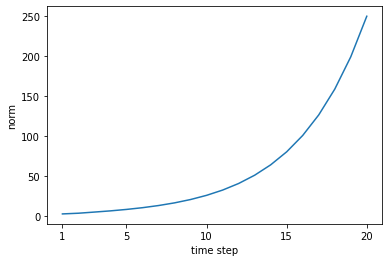

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

図から分かるように、勾配の大きさは回数（時間サイズ）とともに指数関数的に増加している。これが勾配爆発の原因である。また、各重みパラメータを先ほどの実験から半分に変えて同様の実験を行うと、以下のようになる。

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


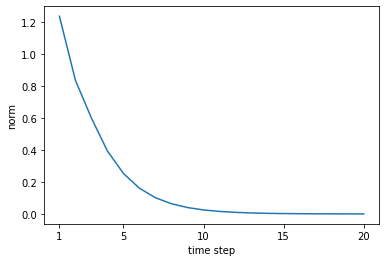

In [6]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

こんどは指数関数的に減少していることがわかる。これは、重みパラメータを繰り返し乗算しているからである。行列には特異値というデータの広がりを表す指標があり、重みパラメータのそれが1を超えれば勾配爆発、1に満たなければ勾配消失がそれぞれ起こる確率が高くなる。

# 勾配爆発ヘの対策
勾配爆発への対策として、**勾配クリッピング**という手法がある。この手法は、疑似コードで表すと以下のようになる。
<br>
$\displaystyle{
\text{if} \quad \|\hat{g}\| \geqq threshold: \\
\qquad \qquad\hat{g} = \frac{threshold}{\|\hat{g}\|}\hat{g}
}$
<br>
ここでは、ニューラルネットワークの全てのパラメータに対する勾配を結合した物を$\hat{g}$として、勾配のL2ノルムが閾値を超えたときに、勾配を式の通りに更新する。これを実装すると以下のようになる。

In [7]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


# 勾配消失とLSTM
勾配消失に対する対策としては、根本的にRNNレイヤのアーキテクチャを変える必要があり、そこを改善した物を「ゲート付きRNN」という。ゲート付きRNNは多くの構成が提案されており、代表例としてはLSTMとGRUがある。ここではLSTMに関して扱う。

# LSTMのインターフェース
LSTMでは、RNNとのインターフェースの違いとして、記憶セルがあることがある。記憶セルは、LSTMレイヤ内で完結し、ほかのレイヤへと出力されることはない。

# LSTMレイヤの組み立て
ゲート付きRNNでは、その名の通りゲートが実装される。LSTMでは、隠れ状態が次の隠れ状態としてどれほど重要かを決めるoutputゲートがある。このゲートの開き具合は、以下の式で表される。
<br>
$\displaystyle{
o = \sigma(x_t W_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})
}$
<br>
また、不要な記憶を忘れるためのforgetゲートがある。これはこの式で表せる。
<br>
$\displaystyle{
f = \sigma(x_t W_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})
}$
<br>
これらのゲートの値は一つ前の時刻の値とのアダマール積を取る形でゲートとして利用される。
また、新しい情報を前の時刻の記憶セルに加算する必要がある。加算する情報$g$は、以下の式で表される。
<br>
$\displaystyle{
g = \text{tanh}(x_t W_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})
}$
<br>
この情報をどの程度の価値として追加するかを管理するゲートがinputゲートであり、以下の式で表される。
<br>
$\displaystyle{
i = \sigma(x_t W_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})
}$
<br>
これらをまとめてLSTMクラスとして実装すると以下のようになる。

In [8]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

これをT個分の時系列データをまとめて処理するように実装すると以下のようになる。

In [9]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# LSTMによる言語モデル
LSTMを利用して、言語モデルを作成する。Rnnlmクラスとして実装したのが以下の例。

In [12]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

このネットワークを用いてPTBデータセットの学習を行う。

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 2965.94
| epoch 1 |  iter 41 / 1327 | time 10[s] | perplexity 1249.82
| epoch 1 |  iter 61 / 1327 | time 17[s] | perplexity 972.61
| epoch 1 |  iter 81 / 1327 | time 22[s] | perplexity 800.97
| epoch 1 |  iter 101 / 1327 | time 29[s] | perplexity 650.52
| epoch 1 |  iter 121 / 1327 | time 35[s] | perplexity 646.93
| epoch 1 |  iter 141 / 1327 | time 41[s] | perplexity 603.71
| epoch 1 |  iter 161 / 1327 | time 46[s] | perplexity 591.74
| epoch 1 |  iter 181 / 1327 | time 51[s] | perplexity 574.47
| epoch 1 |  iter 201 / 1327 | time 56[s] | perplexity 503.40
| epoch 1 |  iter 221 / 1327 | time 61[s] | perplexity 492.53
| epoch 1 |  iter 241 / 1327 | time 67[s] | perplexity 446.62
| epoch 1 |  iter 261 / 1327 | time 72[s] | perplexity 483.89
| epoch 1 |  iter 281 / 1327 | time 77[s] | perplexity 459.57
| epoch 1 |  iter 301 / 1327 | time 83[s] | perplexity 396.62
| epoch 

| epoch 2 |  iter 1261 / 1327 | time 647[s] | perplexity 124.45
| epoch 2 |  iter 1281 / 1327 | time 652[s] | perplexity 122.03
| epoch 2 |  iter 1301 / 1327 | time 656[s] | perplexity 157.08
| epoch 2 |  iter 1321 / 1327 | time 661[s] | perplexity 152.03
| epoch 3 |  iter 1 / 1327 | time 663[s] | perplexity 159.98
| epoch 3 |  iter 21 / 1327 | time 668[s] | perplexity 142.32
| epoch 3 |  iter 41 / 1327 | time 672[s] | perplexity 135.44
| epoch 3 |  iter 61 / 1327 | time 677[s] | perplexity 127.29
| epoch 3 |  iter 81 / 1327 | time 682[s] | perplexity 116.69
| epoch 3 |  iter 101 / 1327 | time 687[s] | perplexity 105.11
| epoch 3 |  iter 121 / 1327 | time 691[s] | perplexity 115.88
| epoch 3 |  iter 141 / 1327 | time 696[s] | perplexity 125.03
| epoch 3 |  iter 161 / 1327 | time 701[s] | perplexity 141.93
| epoch 3 |  iter 181 / 1327 | time 705[s] | perplexity 150.74
| epoch 3 |  iter 201 / 1327 | time 710[s] | perplexity 140.55
| epoch 3 |  iter 221 / 1327 | time 715[s] | perplexity 1

| epoch 4 |  iter 1181 / 1327 | time 1253[s] | perplexity 95.69
| epoch 4 |  iter 1201 / 1327 | time 1258[s] | perplexity 83.95
| epoch 4 |  iter 1221 / 1327 | time 1263[s] | perplexity 76.31
| epoch 4 |  iter 1241 / 1327 | time 1268[s] | perplexity 91.42
| epoch 4 |  iter 1261 / 1327 | time 1272[s] | perplexity 94.10
| epoch 4 |  iter 1281 / 1327 | time 1277[s] | perplexity 89.35
| epoch 4 |  iter 1301 / 1327 | time 1282[s] | perplexity 111.33
| epoch 4 |  iter 1321 / 1327 | time 1286[s] | perplexity 109.03


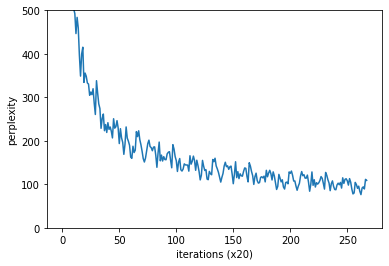

evaluating perplexity ...
234 / 235
test perplexity:  135.73026794303746


In [15]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

perplexityが約136というのはあまりいい結果ではない。このモデルはまだ改良の余地がある。改良できる点としては、以下の3つがある。
- LSTMレイヤの多層化
- Dropoutによる過学習の抑制
- 重み共有

重み共有は、EmbeddingとAffineで同じ重みを使用するというもので、学習精度を高めつつ計算量を抑えられる。これらの改良をもりこんだネットワークを、BetterRnnlmクラスとして実装する。

In [16]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

これを用いて学習する。

In [17]:
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

Done
| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 10000.54
| epoch 1 |  iter 21 / 1327 | time 52[s] | perplexity 3975.31
| epoch 1 |  iter 41 / 1327 | time 101[s] | perplexity 1865.88
| epoch 1 |  iter 61 / 1327 | time 151[s] | perplexity 1283.52
| epoch 1 |  iter 81 / 1327 | time 201[s] | perplexity 1049.99
| epoch 1 |  iter 101 / 1327 | time 249[s] | perplexity 840.32
| epoch 1 |  iter 121 / 1327 | time 298[s] | perplexity 806.39
| epoch 1 |  iter 141 / 1327 | time 347[s] | perplexity 694.89
| epoch 1 |  iter 161 / 1327 | time 397[s] | perplexity 675.78
| epoch 1 |  iter 181 / 1327 | time 443[s] | perplexity 680.89
| epoch 1 |  iter 201 / 1327 | time 490[s] | perplexity 583.20
| epoch 1 |  iter 221 / 1327 | time 538[s] | perplexity 577.67
| epoch 1 |  iter 241 / 1327 | time 587[s] | perplexity 520.32
| epoch 1 |  iter 261 / 1327 | time 635[s] | perplexity 544.10
| epoch 1 |  iter 281 / 1327 | time 684[s] | perplexity 516.41
| epoch 1 |  iter 301 / 1327 | time 732[s] | perplexi

| epoch 2 |  iter 1181 / 1327 | time 2935[s] | perplexity 148.76
| epoch 2 |  iter 1201 / 1327 | time 2985[s] | perplexity 126.47
| epoch 2 |  iter 1221 / 1327 | time 3035[s] | perplexity 124.88
| epoch 2 |  iter 1241 / 1327 | time 3085[s] | perplexity 146.89
| epoch 2 |  iter 1261 / 1327 | time 3136[s] | perplexity 137.84
| epoch 2 |  iter 1281 / 1327 | time 3186[s] | perplexity 141.23
| epoch 2 |  iter 1301 / 1327 | time 3236[s] | perplexity 178.27
| epoch 2 |  iter 1321 / 1327 | time 3286[s] | perplexity 170.62
evaluating perplexity ...
209 / 210
valid perplexity:  146.1509046854264
--------------------------------------------------
| epoch 3 |  iter 1 / 1327 | time 2[s] | perplexity 224.98
| epoch 3 |  iter 21 / 1327 | time 53[s] | perplexity 160.20
| epoch 3 |  iter 41 / 1327 | time 103[s] | perplexity 152.56
| epoch 3 |  iter 61 / 1327 | time 154[s] | perplexity 142.18
| epoch 3 |  iter 81 / 1327 | time 203[s] | perplexity 125.62
| epoch 3 |  iter 101 / 1327 | time 253[s] | perpl

| epoch 4 |  iter 1001 / 1327 | time 2503[s] | perplexity 107.92
| epoch 4 |  iter 1021 / 1327 | time 2553[s] | perplexity 128.35
| epoch 4 |  iter 1041 / 1327 | time 2604[s] | perplexity 111.89
| epoch 4 |  iter 1061 / 1327 | time 2654[s] | perplexity 105.87
| epoch 4 |  iter 1081 / 1327 | time 2704[s] | perplexity 87.87
| epoch 4 |  iter 1101 / 1327 | time 2754[s] | perplexity 91.70
| epoch 4 |  iter 1121 / 1327 | time 2804[s] | perplexity 122.64
| epoch 4 |  iter 1141 / 1327 | time 2854[s] | perplexity 117.21
| epoch 4 |  iter 1161 / 1327 | time 2905[s] | perplexity 101.20
| epoch 4 |  iter 1181 / 1327 | time 2954[s] | perplexity 108.26
| epoch 4 |  iter 1201 / 1327 | time 3004[s] | perplexity 90.63
| epoch 4 |  iter 1221 / 1327 | time 3054[s] | perplexity 90.05
| epoch 4 |  iter 1241 / 1327 | time 3104[s] | perplexity 107.10
| epoch 4 |  iter 1261 / 1327 | time 3154[s] | perplexity 101.81
| epoch 4 |  iter 1281 / 1327 | time 3204[s] | perplexity 102.90
| epoch 4 |  iter 1301 / 1327

| epoch 6 |  iter 841 / 1327 | time 2107[s] | perplexity 95.73
| epoch 6 |  iter 861 / 1327 | time 2156[s] | perplexity 95.28
| epoch 6 |  iter 881 / 1327 | time 2206[s] | perplexity 87.84
| epoch 6 |  iter 901 / 1327 | time 2256[s] | perplexity 111.63
| epoch 6 |  iter 921 / 1327 | time 2306[s] | perplexity 98.36
| epoch 6 |  iter 941 / 1327 | time 2357[s] | perplexity 104.72
| epoch 6 |  iter 961 / 1327 | time 2407[s] | perplexity 111.68
| epoch 6 |  iter 981 / 1327 | time 2457[s] | perplexity 106.57
| epoch 6 |  iter 1001 / 1327 | time 2507[s] | perplexity 91.07
| epoch 6 |  iter 1021 / 1327 | time 2557[s] | perplexity 107.38
| epoch 6 |  iter 1041 / 1327 | time 2607[s] | perplexity 92.08
| epoch 6 |  iter 1061 / 1327 | time 2657[s] | perplexity 88.41
| epoch 6 |  iter 1081 / 1327 | time 2707[s] | perplexity 73.32
| epoch 6 |  iter 1101 / 1327 | time 2758[s] | perplexity 74.93
| epoch 6 |  iter 1121 / 1327 | time 2808[s] | perplexity 102.32
| epoch 6 |  iter 1141 / 1327 | time 2858[

| epoch 8 |  iter 681 / 1327 | time 1701[s] | perplexity 73.83
| epoch 8 |  iter 701 / 1327 | time 1751[s] | perplexity 85.91
| epoch 8 |  iter 721 / 1327 | time 1801[s] | perplexity 87.79
| epoch 8 |  iter 741 / 1327 | time 1852[s] | perplexity 76.41
| epoch 8 |  iter 761 / 1327 | time 1902[s] | perplexity 69.98
| epoch 8 |  iter 781 / 1327 | time 1951[s] | perplexity 76.62
| epoch 8 |  iter 801 / 1327 | time 2001[s] | perplexity 87.82
| epoch 8 |  iter 821 / 1327 | time 2051[s] | perplexity 86.00
| epoch 8 |  iter 841 / 1327 | time 2102[s] | perplexity 86.75
| epoch 8 |  iter 861 / 1327 | time 2152[s] | perplexity 86.03
| epoch 8 |  iter 881 / 1327 | time 2202[s] | perplexity 78.41
| epoch 8 |  iter 901 / 1327 | time 2252[s] | perplexity 99.59
| epoch 8 |  iter 921 / 1327 | time 2303[s] | perplexity 86.92
| epoch 8 |  iter 941 / 1327 | time 2353[s] | perplexity 93.20
| epoch 8 |  iter 961 / 1327 | time 2403[s] | perplexity 101.49
| epoch 8 |  iter 981 / 1327 | time 2453[s] | perplexi

| epoch 10 |  iter 541 / 1327 | time 1350[s] | perplexity 88.08
| epoch 10 |  iter 561 / 1327 | time 1397[s] | perplexity 74.25
| epoch 10 |  iter 581 / 1327 | time 1446[s] | perplexity 68.89
| epoch 10 |  iter 601 / 1327 | time 1494[s] | perplexity 98.45
| epoch 10 |  iter 621 / 1327 | time 1542[s] | perplexity 90.80
| epoch 10 |  iter 641 / 1327 | time 1590[s] | perplexity 84.43
| epoch 10 |  iter 661 / 1327 | time 1638[s] | perplexity 76.80
| epoch 10 |  iter 681 / 1327 | time 1686[s] | perplexity 66.23
| epoch 10 |  iter 701 / 1327 | time 1733[s] | perplexity 79.27
| epoch 10 |  iter 721 / 1327 | time 1780[s] | perplexity 79.51
| epoch 10 |  iter 741 / 1327 | time 1828[s] | perplexity 70.04
| epoch 10 |  iter 761 / 1327 | time 1877[s] | perplexity 64.20
| epoch 10 |  iter 781 / 1327 | time 1926[s] | perplexity 70.32
| epoch 10 |  iter 801 / 1327 | time 1977[s] | perplexity 79.58
| epoch 10 |  iter 821 / 1327 | time 2027[s] | perplexity 78.76
| epoch 10 |  iter 841 / 1327 | time 207

| epoch 12 |  iter 361 / 1327 | time 911[s] | perplexity 82.45
| epoch 12 |  iter 381 / 1327 | time 962[s] | perplexity 69.18
| epoch 12 |  iter 401 / 1327 | time 1013[s] | perplexity 78.18
| epoch 12 |  iter 421 / 1327 | time 1065[s] | perplexity 66.77
| epoch 12 |  iter 441 / 1327 | time 1116[s] | perplexity 72.01
| epoch 12 |  iter 461 / 1327 | time 1167[s] | perplexity 72.03
| epoch 12 |  iter 481 / 1327 | time 1217[s] | perplexity 71.75
| epoch 12 |  iter 501 / 1327 | time 1267[s] | perplexity 79.75
| epoch 12 |  iter 521 / 1327 | time 1317[s] | perplexity 82.74
| epoch 12 |  iter 541 / 1327 | time 1368[s] | perplexity 81.84
| epoch 12 |  iter 561 / 1327 | time 1418[s] | perplexity 70.45
| epoch 12 |  iter 581 / 1327 | time 1469[s] | perplexity 64.60
| epoch 12 |  iter 601 / 1327 | time 1519[s] | perplexity 91.10
| epoch 12 |  iter 621 / 1327 | time 1570[s] | perplexity 85.57
| epoch 12 |  iter 641 / 1327 | time 1620[s] | perplexity 78.54
| epoch 12 |  iter 661 / 1327 | time 1671[

| epoch 14 |  iter 181 / 1327 | time 458[s] | perplexity 82.93
| epoch 14 |  iter 201 / 1327 | time 508[s] | perplexity 81.27
| epoch 14 |  iter 221 / 1327 | time 559[s] | perplexity 79.06
| epoch 14 |  iter 241 / 1327 | time 609[s] | perplexity 74.46
| epoch 14 |  iter 261 / 1327 | time 660[s] | perplexity 78.76
| epoch 14 |  iter 281 / 1327 | time 710[s] | perplexity 77.90
| epoch 14 |  iter 301 / 1327 | time 761[s] | perplexity 63.68
| epoch 14 |  iter 321 / 1327 | time 811[s] | perplexity 52.12
| epoch 14 |  iter 341 / 1327 | time 861[s] | perplexity 75.43
| epoch 14 |  iter 361 / 1327 | time 911[s] | perplexity 77.10
| epoch 14 |  iter 381 / 1327 | time 962[s] | perplexity 66.03
| epoch 14 |  iter 401 / 1327 | time 1012[s] | perplexity 73.17
| epoch 14 |  iter 421 / 1327 | time 1063[s] | perplexity 63.02
| epoch 14 |  iter 441 / 1327 | time 1115[s] | perplexity 67.70
| epoch 14 |  iter 461 / 1327 | time 1167[s] | perplexity 68.68
| epoch 14 |  iter 481 / 1327 | time 1218[s] | perp

| epoch 16 |  iter 1 / 1327 | time 2[s] | perplexity 113.57
| epoch 16 |  iter 21 / 1327 | time 55[s] | perplexity 69.45
| epoch 16 |  iter 41 / 1327 | time 107[s] | perplexity 66.74
| epoch 16 |  iter 61 / 1327 | time 160[s] | perplexity 65.34
| epoch 16 |  iter 81 / 1327 | time 213[s] | perplexity 56.16
| epoch 16 |  iter 101 / 1327 | time 266[s] | perplexity 55.27
| epoch 16 |  iter 121 / 1327 | time 318[s] | perplexity 59.87
| epoch 16 |  iter 141 / 1327 | time 370[s] | perplexity 64.82
| epoch 16 |  iter 161 / 1327 | time 421[s] | perplexity 74.35
| epoch 16 |  iter 181 / 1327 | time 472[s] | perplexity 78.75
| epoch 16 |  iter 201 / 1327 | time 524[s] | perplexity 77.77
| epoch 16 |  iter 221 / 1327 | time 575[s] | perplexity 76.69
| epoch 16 |  iter 241 / 1327 | time 626[s] | perplexity 71.31
| epoch 16 |  iter 261 / 1327 | time 677[s] | perplexity 75.89
| epoch 16 |  iter 281 / 1327 | time 728[s] | perplexity 74.40
| epoch 16 |  iter 301 / 1327 | time 779[s] | perplexity 61.19


| epoch 17 |  iter 1201 / 1327 | time 2985[s] | perplexity 53.23
| epoch 17 |  iter 1221 / 1327 | time 3032[s] | perplexity 51.31
| epoch 17 |  iter 1241 / 1327 | time 3082[s] | perplexity 64.10
| epoch 17 |  iter 1261 / 1327 | time 3130[s] | perplexity 61.04
| epoch 17 |  iter 1281 / 1327 | time 3180[s] | perplexity 60.70
| epoch 17 |  iter 1301 / 1327 | time 3230[s] | perplexity 76.54
| epoch 17 |  iter 1321 / 1327 | time 3279[s] | perplexity 73.19
evaluating perplexity ...
209 / 210
valid perplexity:  86.52618195661078
--------------------------------------------------
| epoch 18 |  iter 1 / 1327 | time 2[s] | perplexity 107.31
| epoch 18 |  iter 21 / 1327 | time 45[s] | perplexity 66.72
| epoch 18 |  iter 41 / 1327 | time 90[s] | perplexity 63.87
| epoch 18 |  iter 61 / 1327 | time 138[s] | perplexity 62.65
| epoch 18 |  iter 81 / 1327 | time 187[s] | perplexity 54.15
| epoch 18 |  iter 101 / 1327 | time 236[s] | perplexity 53.27
| epoch 18 |  iter 121 / 1327 | time 286[s] | perple

| epoch 19 |  iter 1021 / 1327 | time 2619[s] | perplexity 70.74
| epoch 19 |  iter 1041 / 1327 | time 2670[s] | perplexity 61.53
| epoch 19 |  iter 1061 / 1327 | time 2721[s] | perplexity 58.08
| epoch 19 |  iter 1081 / 1327 | time 2772[s] | perplexity 48.71
| epoch 19 |  iter 1101 / 1327 | time 2824[s] | perplexity 49.90
| epoch 19 |  iter 1121 / 1327 | time 2876[s] | perplexity 69.19
| epoch 19 |  iter 1141 / 1327 | time 2927[s] | perplexity 65.70
| epoch 19 |  iter 1161 / 1327 | time 2977[s] | perplexity 53.88
| epoch 19 |  iter 1181 / 1327 | time 3028[s] | perplexity 61.83
| epoch 19 |  iter 1201 / 1327 | time 3079[s] | perplexity 51.80
| epoch 19 |  iter 1221 / 1327 | time 3130[s] | perplexity 50.15
| epoch 19 |  iter 1241 / 1327 | time 3181[s] | perplexity 62.50
| epoch 19 |  iter 1261 / 1327 | time 3232[s] | perplexity 58.56
| epoch 19 |  iter 1281 / 1327 | time 3284[s] | perplexity 59.41
| epoch 19 |  iter 1301 / 1327 | time 3335[s] | perplexity 74.25
| epoch 19 |  iter 1321 /

| epoch 21 |  iter 841 / 1327 | time 2014[s] | perplexity 52.22
| epoch 21 |  iter 861 / 1327 | time 2049[s] | perplexity 52.49
| epoch 21 |  iter 881 / 1327 | time 2087[s] | perplexity 47.90
| epoch 21 |  iter 901 / 1327 | time 2124[s] | perplexity 61.53
| epoch 21 |  iter 921 / 1327 | time 2159[s] | perplexity 53.89
| epoch 21 |  iter 941 / 1327 | time 2196[s] | perplexity 57.75
| epoch 21 |  iter 961 / 1327 | time 2232[s] | perplexity 61.11
| epoch 21 |  iter 981 / 1327 | time 2268[s] | perplexity 57.76
| epoch 21 |  iter 1001 / 1327 | time 2304[s] | perplexity 49.58
| epoch 21 |  iter 1021 / 1327 | time 2340[s] | perplexity 58.09
| epoch 21 |  iter 1041 / 1327 | time 2377[s] | perplexity 49.88
| epoch 21 |  iter 1061 / 1327 | time 2413[s] | perplexity 48.12
| epoch 21 |  iter 1081 / 1327 | time 2450[s] | perplexity 40.01
| epoch 21 |  iter 1101 / 1327 | time 2486[s] | perplexity 39.43
| epoch 21 |  iter 1121 / 1327 | time 2521[s] | perplexity 54.37
| epoch 21 |  iter 1141 / 1327 | 

| epoch 23 |  iter 661 / 1327 | time 1613[s] | perplexity 48.53
| epoch 23 |  iter 681 / 1327 | time 1662[s] | perplexity 42.63
| epoch 23 |  iter 701 / 1327 | time 1710[s] | perplexity 50.58
| epoch 23 |  iter 721 / 1327 | time 1759[s] | perplexity 50.31
| epoch 23 |  iter 741 / 1327 | time 1808[s] | perplexity 45.72
| epoch 23 |  iter 761 / 1327 | time 1857[s] | perplexity 40.50
| epoch 23 |  iter 781 / 1327 | time 1906[s] | perplexity 44.43
| epoch 23 |  iter 801 / 1327 | time 1955[s] | perplexity 50.93
| epoch 23 |  iter 821 / 1327 | time 2003[s] | perplexity 50.76
| epoch 23 |  iter 841 / 1327 | time 2052[s] | perplexity 50.49
| epoch 23 |  iter 861 / 1327 | time 2100[s] | perplexity 50.37
| epoch 23 |  iter 881 / 1327 | time 2148[s] | perplexity 45.87
| epoch 23 |  iter 901 / 1327 | time 2197[s] | perplexity 58.10
| epoch 23 |  iter 921 / 1327 | time 2246[s] | perplexity 51.61
| epoch 23 |  iter 941 / 1327 | time 2294[s] | perplexity 55.54
| epoch 23 |  iter 961 / 1327 | time 234

| epoch 25 |  iter 481 / 1327 | time 1184[s] | perplexity 48.08
| epoch 25 |  iter 501 / 1327 | time 1229[s] | perplexity 51.55
| epoch 25 |  iter 521 / 1327 | time 1276[s] | perplexity 53.64
| epoch 25 |  iter 541 / 1327 | time 1322[s] | perplexity 55.27
| epoch 25 |  iter 561 / 1327 | time 1369[s] | perplexity 44.29
| epoch 25 |  iter 581 / 1327 | time 1415[s] | perplexity 42.56
| epoch 25 |  iter 601 / 1327 | time 1464[s] | perplexity 60.07
| epoch 25 |  iter 621 / 1327 | time 1513[s] | perplexity 55.06
| epoch 25 |  iter 641 / 1327 | time 1561[s] | perplexity 51.30
| epoch 25 |  iter 661 / 1327 | time 1610[s] | perplexity 46.31
| epoch 25 |  iter 681 / 1327 | time 1659[s] | perplexity 41.48
| epoch 25 |  iter 701 / 1327 | time 1708[s] | perplexity 49.26
| epoch 25 |  iter 721 / 1327 | time 1757[s] | perplexity 48.37
| epoch 25 |  iter 741 / 1327 | time 1805[s] | perplexity 43.87
| epoch 25 |  iter 761 / 1327 | time 1854[s] | perplexity 38.90
| epoch 25 |  iter 781 / 1327 | time 190

| epoch 27 |  iter 301 / 1327 | time 731[s] | perplexity 42.44
| epoch 27 |  iter 321 / 1327 | time 779[s] | perplexity 35.08
| epoch 27 |  iter 341 / 1327 | time 828[s] | perplexity 49.37
| epoch 27 |  iter 361 / 1327 | time 877[s] | perplexity 50.34
| epoch 27 |  iter 381 / 1327 | time 925[s] | perplexity 43.53
| epoch 27 |  iter 401 / 1327 | time 974[s] | perplexity 49.30
| epoch 27 |  iter 421 / 1327 | time 1023[s] | perplexity 42.46
| epoch 27 |  iter 441 / 1327 | time 1071[s] | perplexity 44.97
| epoch 27 |  iter 461 / 1327 | time 1120[s] | perplexity 45.05
| epoch 27 |  iter 481 / 1327 | time 1169[s] | perplexity 46.57
| epoch 27 |  iter 501 / 1327 | time 1218[s] | perplexity 49.12
| epoch 27 |  iter 521 / 1327 | time 1266[s] | perplexity 51.52
| epoch 27 |  iter 541 / 1327 | time 1314[s] | perplexity 52.16
| epoch 27 |  iter 561 / 1327 | time 1363[s] | perplexity 43.16
| epoch 27 |  iter 581 / 1327 | time 1411[s] | perplexity 39.87
| epoch 27 |  iter 601 / 1327 | time 1460[s] |

| epoch 29 |  iter 121 / 1327 | time 293[s] | perplexity 41.31
| epoch 29 |  iter 141 / 1327 | time 341[s] | perplexity 44.48
| epoch 29 |  iter 161 / 1327 | time 389[s] | perplexity 52.62
| epoch 29 |  iter 181 / 1327 | time 437[s] | perplexity 54.19
| epoch 29 |  iter 201 / 1327 | time 486[s] | perplexity 54.15
| epoch 29 |  iter 221 / 1327 | time 534[s] | perplexity 52.55
| epoch 29 |  iter 241 / 1327 | time 582[s] | perplexity 49.43
| epoch 29 |  iter 261 / 1327 | time 632[s] | perplexity 52.53
| epoch 29 |  iter 281 / 1327 | time 681[s] | perplexity 51.99
| epoch 29 |  iter 301 / 1327 | time 730[s] | perplexity 41.80
| epoch 29 |  iter 321 / 1327 | time 779[s] | perplexity 34.57
| epoch 29 |  iter 341 / 1327 | time 827[s] | perplexity 48.37
| epoch 29 |  iter 361 / 1327 | time 876[s] | perplexity 49.62
| epoch 29 |  iter 381 / 1327 | time 924[s] | perplexity 42.82
| epoch 29 |  iter 401 / 1327 | time 973[s] | perplexity 48.49
| epoch 29 |  iter 421 / 1327 | time 1021[s] | perplexi

| epoch 30 |  iter 1321 / 1327 | time 3207[s] | perplexity 47.82
evaluating perplexity ...
209 / 210
valid perplexity:  80.2906017282304
--------------------------------------------------
| epoch 31 |  iter 1 / 1327 | time 2[s] | perplexity 80.90
| epoch 31 |  iter 21 / 1327 | time 51[s] | perplexity 48.29
| epoch 31 |  iter 41 / 1327 | time 99[s] | perplexity 46.50
| epoch 31 |  iter 61 / 1327 | time 147[s] | perplexity 45.01
| epoch 31 |  iter 81 / 1327 | time 196[s] | perplexity 39.19
| epoch 31 |  iter 101 / 1327 | time 245[s] | perplexity 38.46
| epoch 31 |  iter 121 / 1327 | time 294[s] | perplexity 41.61
| epoch 31 |  iter 141 / 1327 | time 343[s] | perplexity 43.17
| epoch 31 |  iter 161 / 1327 | time 391[s] | perplexity 52.32
| epoch 31 |  iter 181 / 1327 | time 440[s] | perplexity 54.57
| epoch 31 |  iter 201 / 1327 | time 489[s] | perplexity 54.97
| epoch 31 |  iter 221 / 1327 | time 537[s] | perplexity 52.05
| epoch 31 |  iter 241 / 1327 | time 585[s] | perplexity 48.22
| e

| epoch 32 |  iter 1141 / 1327 | time 2811[s] | perplexity 44.08
| epoch 32 |  iter 1161 / 1327 | time 2860[s] | perplexity 36.58
| epoch 32 |  iter 1181 / 1327 | time 2908[s] | perplexity 40.48
| epoch 32 |  iter 1201 / 1327 | time 2957[s] | perplexity 33.86
| epoch 32 |  iter 1221 / 1327 | time 3006[s] | perplexity 34.30
| epoch 32 |  iter 1241 / 1327 | time 3054[s] | perplexity 41.51
| epoch 32 |  iter 1261 / 1327 | time 3103[s] | perplexity 40.64
| epoch 32 |  iter 1281 / 1327 | time 3152[s] | perplexity 39.52
| epoch 32 |  iter 1301 / 1327 | time 3203[s] | perplexity 48.02
| epoch 32 |  iter 1321 / 1327 | time 3251[s] | perplexity 48.44
evaluating perplexity ...
209 / 210
valid perplexity:  80.25944294841037
--------------------------------------------------
| epoch 33 |  iter 1 / 1327 | time 2[s] | perplexity 72.74
| epoch 33 |  iter 21 / 1327 | time 51[s] | perplexity 48.43
| epoch 33 |  iter 41 / 1327 | time 100[s] | perplexity 46.02
| epoch 33 |  iter 61 / 1327 | time 149[s] |

| epoch 34 |  iter 961 / 1327 | time 2347[s] | perplexity 50.80
| epoch 34 |  iter 981 / 1327 | time 2396[s] | perplexity 49.22
| epoch 34 |  iter 1001 / 1327 | time 2444[s] | perplexity 40.74
| epoch 34 |  iter 1021 / 1327 | time 2493[s] | perplexity 47.89
| epoch 34 |  iter 1041 / 1327 | time 2542[s] | perplexity 42.37
| epoch 34 |  iter 1061 / 1327 | time 2590[s] | perplexity 39.46
| epoch 34 |  iter 1081 / 1327 | time 2640[s] | perplexity 33.19
| epoch 34 |  iter 1101 / 1327 | time 2689[s] | perplexity 33.52
| epoch 34 |  iter 1121 / 1327 | time 2738[s] | perplexity 45.84
| epoch 34 |  iter 1141 / 1327 | time 2788[s] | perplexity 44.18
| epoch 34 |  iter 1161 / 1327 | time 2837[s] | perplexity 36.82
| epoch 34 |  iter 1181 / 1327 | time 2886[s] | perplexity 41.25
| epoch 34 |  iter 1201 / 1327 | time 2936[s] | perplexity 34.17
| epoch 34 |  iter 1221 / 1327 | time 2985[s] | perplexity 34.22
| epoch 34 |  iter 1241 / 1327 | time 3034[s] | perplexity 41.48
| epoch 34 |  iter 1261 / 1

| epoch 36 |  iter 781 / 1327 | time 1899[s] | perplexity 39.30
| epoch 36 |  iter 801 / 1327 | time 1949[s] | perplexity 44.61
| epoch 36 |  iter 821 / 1327 | time 1998[s] | perplexity 44.52
| epoch 36 |  iter 841 / 1327 | time 2048[s] | perplexity 43.91
| epoch 36 |  iter 861 / 1327 | time 2097[s] | perplexity 43.99
| epoch 36 |  iter 881 / 1327 | time 2146[s] | perplexity 40.64
| epoch 36 |  iter 901 / 1327 | time 2195[s] | perplexity 51.97
| epoch 36 |  iter 921 / 1327 | time 2244[s] | perplexity 45.37
| epoch 36 |  iter 941 / 1327 | time 2293[s] | perplexity 48.75
| epoch 36 |  iter 961 / 1327 | time 2341[s] | perplexity 51.66
| epoch 36 |  iter 981 / 1327 | time 2390[s] | perplexity 49.14
| epoch 36 |  iter 1001 / 1327 | time 2439[s] | perplexity 41.78
| epoch 36 |  iter 1021 / 1327 | time 2488[s] | perplexity 48.65
| epoch 36 |  iter 1041 / 1327 | time 2537[s] | perplexity 42.04
| epoch 36 |  iter 1061 / 1327 | time 2585[s] | perplexity 39.90
| epoch 36 |  iter 1081 / 1327 | tim

| epoch 38 |  iter 601 / 1327 | time 1472[s] | perplexity 56.35
| epoch 38 |  iter 621 / 1327 | time 1521[s] | perplexity 50.65
| epoch 38 |  iter 641 / 1327 | time 1570[s] | perplexity 46.68
| epoch 38 |  iter 661 / 1327 | time 1619[s] | perplexity 42.67
| epoch 38 |  iter 681 / 1327 | time 1668[s] | perplexity 37.69
| epoch 38 |  iter 701 / 1327 | time 1717[s] | perplexity 44.35
| epoch 38 |  iter 721 / 1327 | time 1766[s] | perplexity 44.54
| epoch 38 |  iter 741 / 1327 | time 1815[s] | perplexity 40.73
| epoch 38 |  iter 761 / 1327 | time 1865[s] | perplexity 36.17
| epoch 38 |  iter 781 / 1327 | time 1914[s] | perplexity 39.14
| epoch 38 |  iter 801 / 1327 | time 1963[s] | perplexity 44.11
| epoch 38 |  iter 821 / 1327 | time 2012[s] | perplexity 44.77
| epoch 38 |  iter 841 / 1327 | time 2061[s] | perplexity 43.93
| epoch 38 |  iter 861 / 1327 | time 2110[s] | perplexity 43.97
| epoch 38 |  iter 881 / 1327 | time 2158[s] | perplexity 40.41
| epoch 38 |  iter 901 / 1327 | time 220

| epoch 40 |  iter 421 / 1327 | time 1031[s] | perplexity 40.71
| epoch 40 |  iter 441 / 1327 | time 1079[s] | perplexity 43.04
| epoch 40 |  iter 461 / 1327 | time 1129[s] | perplexity 43.61
| epoch 40 |  iter 481 / 1327 | time 1177[s] | perplexity 44.34
| epoch 40 |  iter 501 / 1327 | time 1226[s] | perplexity 47.72
| epoch 40 |  iter 521 / 1327 | time 1275[s] | perplexity 49.23
| epoch 40 |  iter 541 / 1327 | time 1323[s] | perplexity 50.19
| epoch 40 |  iter 561 / 1327 | time 1372[s] | perplexity 41.16
| epoch 40 |  iter 581 / 1327 | time 1421[s] | perplexity 38.68
| epoch 40 |  iter 601 / 1327 | time 1469[s] | perplexity 56.20
| epoch 40 |  iter 621 / 1327 | time 1519[s] | perplexity 50.21
| epoch 40 |  iter 641 / 1327 | time 1568[s] | perplexity 46.34
| epoch 40 |  iter 661 / 1327 | time 1616[s] | perplexity 42.83
| epoch 40 |  iter 681 / 1327 | time 1665[s] | perplexity 37.40
| epoch 40 |  iter 701 / 1327 | time 1714[s] | perplexity 45.24
| epoch 40 |  iter 721 / 1327 | time 176

学習にかなりの時間を要したが、改善前のperplexityが約136であったことから、かなりの精度向上が達成できたことがわかる。